# Time Series Anomaly Detector

We will use a concept known as Bollinger Bands to discover when behavior changes from what is "expected" or normal. Bollinger Bands is a volatility indicator and commonly used in stock market trading. 

Scenario: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum? 

We will accomplish this by breaking down to the following tasks:

1. acquire the data
2. prepare the data
3. make the analysis process (which we will discuss later) work over all users. 
4. Turn the analysis process and calculations into a function that can be used to loop through for each user. 
5. Test the function on a single user. 
6. Analyze by looping over all users. 

The analysis process will look like this, for each user: 

1. compute necessary metrics to arrive at the final metric, %b (percent-b).
2. add user id to the dataframe that contains all the metrics, including %b. 
3. filter to rows where %b indicates anomaly (i.e. > 1)
4. append rows of anomalies of new user to previous users' anomalous activity. 

Finally, we will do a quick sample of exploration of the anomalies. There is much more you can do! 

Your exercise will be to add comments, markdown, and docstrings to the code in this lesson. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# from matplotlib import style
import seaborn as sns
%matplotlib inline

# pd.plotting.register_matplotlib_converters()


**Acquire**

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly. 

In [2]:
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


**Prepare**


In [3]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

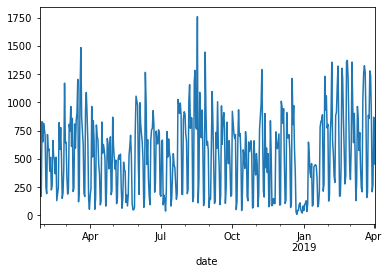

In [4]:
pages.plot()

No need to split because we are not modeling, we are using statistics to identify low probability cases. 

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [5]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [6]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [7]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [8]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

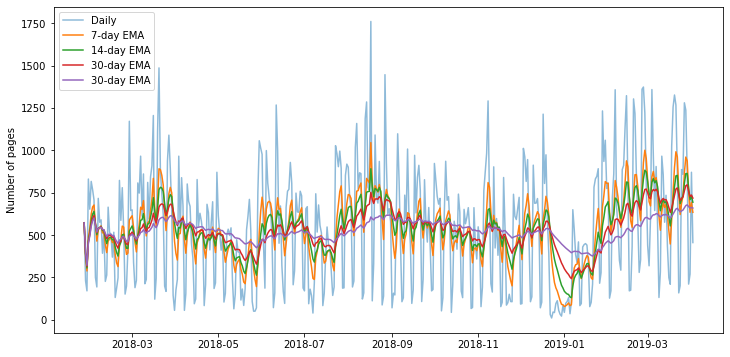

In [9]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [10]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [11]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [12]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2019-03-29    2010.826118
2019-03-30    2012.546246
2019-03-31    1994.013613
2019-04-01    1966.416830
2019-04-02    1926.400861
Freq: D, Name: endpoint, Length: 432, dtype: float64

In [13]:
lb

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
                 ...    
2019-03-29   -419.230257
2019-03-30   -496.537215
2019-03-31   -541.101938
2019-04-01   -494.983328
2019-04-02   -491.188875
Freq: D, Name: endpoint, Length: 432, dtype: float64

In [14]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [15]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


Plot the bands

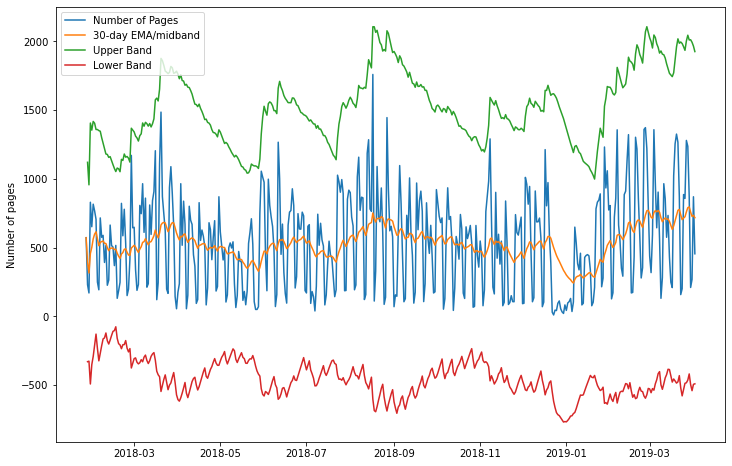

In [17]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [18]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure

455.0

In [19]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-491.1888751441477

In [20]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

1926.4008608312927

In [21]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.39


In [22]:
my_df.tail(3)

,pages,midband,ub,lb
date,,,,
2019-03-31,269,726.455837,1994.013613,-541.101938
2019-04-01,870,735.716751,1966.416830,-494.983328
2019-04-02,455,717.605993,1926.400861,-491.188875


So, to compute for each point in time: 

In [23]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [24]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


## Pull it all together!

1. acquire
2. prep with user
3. compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. search for anomalies

In [25]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

Acquire

In [26]:
file_name = "anonymized-curriculum-access.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


Test on a single user

In [27]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

Loop through all users 

In [28]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

Explore anomalies

In [29]:
anomalies.pages.value_counts(sort=False)

1       5
2       2
3       7
4      12
5       4
6      12
7       8
8       9
9      10
10     11
11     15
12      8
13     12
14      4
15      5
16      6
17      6
18      9
19      8
20      3
21      1
22      2
23      3
24      3
25      5
26      2
27      4
28      4
29      2
30      4
31      2
32      4
33      3
34      4
35      1
36      2
38      2
40      2
41      1
42      2
44      2
45      1
46      1
47      1
48      1
55      1
59      1
60      1
62      2
67      2
73      1
74      3
78      1
84      1
96      1
107     1
153     1
272     1
198     1
Name: pages, dtype: int64

In [30]:
anomalies[anomalies.pages==272]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


hmmmmmmmmmmm.......

In [31]:
anomalies[anomalies.user_id==341]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


In [32]:
df[df.user_id==341]

,date,endpoint,user_id,cohort_id,source_ip
181808,2019-01-22,/,341,29.0,97.105.19.58
181826,2019-01-22,toc,341,29.0,97.105.19.58
181840,2019-01-22,html-css,341,29.0,97.105.19.58
181862,2019-01-22,html-css/introduction,341,29.0,97.105.19.58
181870,2019-01-22,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...
232331,2019-04-01,java-ii/collections,341,29.0,97.105.19.58
233195,2019-04-02,java-ii/annotations,341,29.0,97.105.19.58
233196,2019-04-02,java-ii/exceptions-and-error-handling,341,29.0,97.105.19.58
233197,2019-04-02,java-ii/collections,341,29.0,97.105.19.58


This is worth investigating! 

## Exercises

**file name:** time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is `curriculum_logs`.

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening. 

Bonus:

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Can you label students who are viewing both the web dev and data science curriculum?
Can you label students by the program they are in? 
Can you label users by student vs. staff?